Copyright 2018 Manan Shukla

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Explaining the predictions with K-LIME

K-LIME generates global and local explanations that increase the transparency of the Driverless AI model, and allow model behavior to be validated and debugged by analyzing the provided plots, and comparing global and local explanations to one-another, to known standards, to domain knowledge, and to reasonable expectations.

K-LIME creates one global surrogate GLM on the entire training data and also creates numerous local surrogate GLMs on samples formed from k-means clusters in the training data. All penalized GLM surrogates are trained to model the predictions of the Driverless AI model. The number of clusters for local explanations is chosen by a grid search in which the between the Driverless AI model predictions and all of the local K-LIME model predictions is maximized.

References: https://www.h2o.ai/wp-content/uploads/2017/09/driverlessai/interpreting.html

In [3]:
# import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # for LIME
from h2o.estimators.gbm import H2OGradientBoostingEstimator  # for GBM

import operator # for sorting dictionaries

import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling

# display plots in notebook
%matplotlib inline


In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from C:\Users\manan\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\manan\AppData\Local\Temp\tmpjy2v1_79
  JVM stdout: C:\Users\manan\AppData\Local\Temp\tmpjy2v1_79\h2o_Manan_Shukla_started_from_python.out
  JVM stderr: C:\Users\manan\AppData\Local\Temp\tmpjy2v1_79\h2o_Manan_Shukla_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.9
H2O cluster version age:,2 months and 4 days
H2O cluster name:,H2O_from_python_Manan_Shukla_cljga7
H2O cluster total nodes:,1
H2O cluster free memory:,3.530 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients



In [10]:
path = 'C:/Users/manan/Desktop/Engineering Management/Fall 2018/Independent Study/Dataset/default of credit card clients.csv'
data = pd.read_csv(path,skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'})

In [11]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [12]:
def recode_cc_data(frame):
    
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 
    
    Args:
        frame: Pandas DataFrame version of UCI credit card default data.
        
    Returns: 
        H2OFrame with recoded values.
        
    """
    
    # define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict = {-2:'no consumption', -1:'pay duly', 0:'use of revolving credit', 1:'1 month delay', 
                2:'2 month delay', 3:'3 month delay', 4:'4 month delay', 5:'5 month delay', 6:'6 month delay', 
                7:'7 month delay', 8:'8 month delay', 9:'9+ month delay'}
    
    # recode values using Pandas apply() and anonymous function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i]) 
    for name in frame.columns:
        if name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            frame[name] = frame[name].apply(lambda i: pay_dict[i])            
                
    return h2o.H2OFrame(frame)

data = recode_cc_data(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [13]:
#The target variable DEFAULT_NEXT_MONTH takes on values of 0 or  1. 
#To ensure this numeric variable is treated as a categorical variable, the asfactor() function is used
data[y] = data[y].asfactor()

In [14]:
data.describe()

Rows:30000
Cols:25




,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
type,int,int,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,int,int,enum
mins,1.0,10000.0,,,,21.0,,,,,,,-165580.0,-69777.0,-157264.0,-170000.0,-81334.0,-339603.0,0.0,0.0,0.0,0.0,0.0,0.0,
mean,15000.5,167484.32266666615,,,,35.48549999999997,,,,,,,51223.33089999999,49179.07516666671,47013.15479999975,43262.94896666657,40311.40096666653,38871.76039999989,5663.580500000012,5921.163500000002,5225.6815000000115,4826.076866666665,4799.387633333305,5215.502566666666,
maxs,30000.0,1000000.0,,,,79.0,,,,,,,964511.0,983931.0,1664089.0,891586.0,927171.0,961664.0,873552.0,1684259.0,896040.0,621000.0,426529.0,528666.0,
sigma,8660.398374208891,129747.66156720235,,,,9.217904068090167,,,,,,,73635.86057552959,71173.76878252836,69349.38742703672,64332.85613391646,60797.155770264806,59554.10753674582,16563.280354025756,23040.870402057226,17606.961469803104,15666.159744031977,15278.305679144802,17777.465775435325,
zeros,0,0,,,,0,,,,,,,2008,2506,2870,3195,3506,4020,5249,5396,5968,6408,6703,7173,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,20000.0,female,university,married,24.0,2 month delay,2 month delay,pay duly,pay duly,no consumption,no consumption,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2.0,120000.0,female,university,single,26.0,pay duly,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,2 month delay,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3.0,90000.0,female,university,single,34.0,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


## Training a H2O GBM Classifier

In [15]:
# split into training and validation
train, test = data.split_frame([0.7], seed=12345)

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 21060, columns = 25
Test data rows = 8940, columns = 25


In [16]:
# initialize GBM model
model = H2OGradientBoostingEstimator(ntrees=150,            # maximum 150 trees in GBM
                                     max_depth=4,           # trees can have maximum depth of 4
                                     sample_rate=0.9,       # use 90% of rows in each iteration (tree)
                                     col_sample_rate=0.9,   # use 90% of variables in each iteration (tree)
                                     stopping_rounds=5,     # stop if validation error does not decrease for 5 iterations (trees)
                                     score_tree_interval=1, # for reproducibility, set higher for bigger data
                                     seed=12345)            # random seed for reproducibility

# train a GBM model
model.train(y=y, x=X, training_frame=train, validation_frame=test)

# print AUC
print('GBM Test AUC = %.2f' % model.auc(valid=True))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Test AUC = 0.78


In [17]:
#diplaying the most risky customer

row = test[test['ID'] == 29116]
row

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
29116,20000,female,university,married,59,3 month delay,2 month delay,3 month delay,2 month delay,2 month delay,4 month delay,8803,11137,10672,11201,12721,11946,2800,0,1000,2000,0,0,1


In [18]:
def generate_local_sample(row, frame, X, N=1000):
    
    """ Generates a perturbed sample around a row of interest.
    
    Args:
        row: Row of H2OFrame to be explained.
        frame: H2OFrame in which row is stored.
        X: List of model input variables.
        N: Number of samples to generate.
    
    Returns:
        Pandas DataFrame containing perturbed sample.
    
    """
    
    # initialize Pandas DataFrame
    sample_frame = pd.DataFrame(data=np.zeros(shape=(N, len(X))), columns=X)
    
    # generate column vectors of 
    # randomly drawn levels for categorical variables
    # normally distributed numeric values around mean of column for numeric variables
    for key, val in frame[X].types.items():
        if val == 'enum': # 'enum' means categorical
            rs = np.random.RandomState(11111) # random seed for reproducibility
            draw = rs.choice(frame[key].levels()[0], size=(1, N))[0]
        else:
            rs = np.random.RandomState(11111) # random seed for reproducibility
            loc = row[key][0, 0]
            sd = frame[key].sd()
            draw = rs.normal(loc, sd, (N, 1))
            draw[draw < 0] = loc # prevents unrealistic values when std. dev. is large
        
        sample_frame[key] = draw
        
    return sample_frame

# run and display results
perturbed_sample = generate_local_sample(row, test, X)
perturbed_sample.head(n=3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,9988.454213,female,graduate school,divorced,58.287510,5 month delay,5 month delay,5 month delay,5 month delay,6 month delay,...,5433.340804,6276.576876,8055.530587,7347.467911,1597.834490,0.000000,1000.000000,823.253257,0.000000,0.000000
1,181039.642122,male,high school,married,70.460689,pay duly,pay duly,pay duly,pay duly,use of revolving credit,...,94937.888614,90412.278099,87766.906051,85915.192926,22137.303918,25583.930273,21802.010398,20928.433066,19123.775929,22563.515833
2,20000.000000,male,university,single,43.284233,7 month delay,7 month delay,7 month delay,7 month delay,8 month delay,...,10672.000000,11201.000000,12721.000000,11946.000000,2800.000000,0.000000,1000.000000,2000.000000,0.000000,0.000000


In [19]:
# scaling and one-hot encoding for calculating Euclidian distance
# for the row of interest

# scale numeric
numeric = list(set(X) - set(['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
                             'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT_NEXT_MONTH']))

scaled_test = test.as_data_frame()
scaled_test[numeric] = (scaled_test[numeric] - scaled_test[numeric].mean())/scaled_test[numeric].std()
    
# encode categorical
row_df = scaled_test[scaled_test['ID'] == 22760]
row_dummies = pd.concat([row_df.drop(['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
                                      'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT_NEXT_MONTH'], axis=1),
                        pd.get_dummies(row_df[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
                                               'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']])], 
                        axis=1)

# convert to H2OFrame
row_dummies = h2o.H2OFrame(row_dummies)
row_dummies

Parse progress: |█████████████████████████████████████████████████████████| 100%


LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_female,EDUCATION_graduate school,MARRIAGE_married,PAY_0_3 month delay,PAY_2_2 month delay,PAY_3_2 month delay,PAY_4_3 month delay,PAY_5_3 month delay,PAY_6_3 month delay
2.24639,0.481433,-0.66112,-0.657958,-0.651883,-0.637776,-0.622867,-0.609179,-0.360791,-0.282325,-0.315203,-0.319038,-0.319074,-0.270536,1,1,1,1,1,1,1,1,1


In [20]:
# scaling and one-hot encoding for calculating Euclidian distance 
# for the simulated sample

# scale
scaled_perturbed_sample = perturbed_sample[numeric].copy(deep=True)
scaled_perturbed_sample = (scaled_perturbed_sample - scaled_perturbed_sample.mean())/scaled_perturbed_sample.std()

# encode
perturbed_sample_dummies = pd.concat([scaled_perturbed_sample,
                                      pd.get_dummies(perturbed_sample[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
                                                                       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']])],
                                     axis=1)

# convert to H2OFrame
perturbed_sample_dummies = h2o.H2OFrame(perturbed_sample_dummies[row_dummies.columns])
perturbed_sample_dummies.head(rows=3)

Parse progress: |█████████████████████████████████████████████████████████| 100%


LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_female,EDUCATION_graduate school,MARRIAGE_married,PAY_0_3 month delay,PAY_2_2 month delay,PAY_3_2 month delay,PAY_4_3 month delay,PAY_5_3 month delay,PAY_6_3 month delay
-0.845634,-0.0955699,-0.84979,-0.845174,-0.845174,-0.83886,-0.834367,-0.834967,-0.83834,-0.723503,-0.722209,-0.849042,-0.723503,-0.723503,1,1,0,0,0,0,0,0,0
1.41903,1.2011,1.41949,1.41897,1.41897,1.4182,1.4176,1.41769,1.41814,1.41999,1.41993,1.41941,1.41999,1.41999,0,0,1,0,0,0,0,0,0
-0.713084,-1.69369,-0.716971,-0.712654,-0.712654,-0.706755,-0.70256,-0.70312,-0.706269,-0.723503,-0.722209,-0.716271,-0.723503,-0.723503,0,0,0,0,0,0,0,0,0


In [21]:
# calculate distance using H2OFrame distance function
distance = row_dummies.distance(perturbed_sample_dummies, measure='l2').transpose()
distance.columns = ['distance']          # rename 
distance = distance.max() - distance     # lower distances, higher weight in LIME
distance.head(rows=3)

distance
287.907
253.673
282.757


In [22]:
perturbed_sample = h2o.H2OFrame(perturbed_sample).cbind(distance)
perturbed_sample.head(rows=3)

Parse progress: |█████████████████████████████████████████████████████████| 100%


LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,distance
9988.45,female,graduate school,divorced,58.2875,5 month delay,5 month delay,5 month delay,5 month delay,6 month delay,6 month delay,3152.62,5678.04,5433.34,6276.58,8055.53,7347.47,1597.83,0,1000,823.253,0,0,287.907
181040,male,high school,married,70.4607,pay duly,pay duly,pay duly,pay duly,use of revolving credit,use of revolving credit,99691.6,98946.5,94937.9,90412.3,87766.9,85915.2,22137.3,25583.9,21802,20928.4,19123.8,22563.5,253.673
20000,male,university,single,43.2842,7 month delay,7 month delay,7 month delay,7 month delay,8 month delay,8 month delay,8803,11137,10672,11201,12721,11946,2800,0,1000,2000,0,0,282.757


In [23]:
yhat = 'p_DEFAULT_NEXT_MONTH'
preds1 = model.predict(perturbed_sample).drop(['predict', 'p0'])
preds1.columns = [yhat]
perturbed_sample = perturbed_sample.cbind(preds1)
perturbed_sample.head(rows=3)

gbm prediction progress: |████████████████████████████████████████████████| 100%


LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,distance,p_DEFAULT_NEXT_MONTH
9988.45,female,graduate school,divorced,58.2875,5 month delay,5 month delay,5 month delay,5 month delay,6 month delay,6 month delay,3152.62,5678.04,5433.34,6276.58,8055.53,7347.47,1597.83,0,1000,823.253,0,0,287.907,0.515197
181040,male,high school,married,70.4607,pay duly,pay duly,pay duly,pay duly,use of revolving credit,use of revolving credit,99691.6,98946.5,94937.9,90412.3,87766.9,85915.2,22137.3,25583.9,21802,20928.4,19123.8,22563.5,253.673,0.0663977
20000,male,university,single,43.2842,7 month delay,7 month delay,7 month delay,7 month delay,8 month delay,8 month delay,8803,11137,10672,11201,12721,11946,2800,0,1000,2000,0,0,282.757,0.692681


In [24]:
# initialize
local_glm1 = H2OGeneralizedLinearEstimator(lambda_search=True, 
                                           weights_column='distance',
                                           seed=12345)
# train 
local_glm1.train(x=X, y=yhat, training_frame=perturbed_sample)

# coefs
print('\nLocal Positive GLM Coefficients:')
for c_name, c_val in sorted(local_glm1.coef().items(), key=operator.itemgetter(1)):
    if c_val > 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))
        
# r2
print('\nLocal GLM R-square:\n%.2f' % local_glm1.r2())

glm Model Build progress: |███████████████████████████████████████████████| 100%

Local Positive GLM Coefficients:
PAY_6.5 month delay:      0.00012336828327573496
PAY_6.8 month delay:      0.00017180686755454105
AGE:                      0.0005214813169894424
MARRIAGE.divorced:        0.0009908636978080935
PAY_5.5 month delay:      0.0029210607400757278
PAY_5.8 month delay:      0.0034766652812415477
MARRIAGE.married:         0.008394498329108364
EDUCATION.graduate school: 0.008778594515508074
PAY_4.8 month delay:      0.009194057851983514
PAY_6.2 month delay:      0.010989810282325953
PAY_3.8 month delay:      0.011784255155208112
PAY_4.4 month delay:      0.013724839005142249
PAY_2.8 month delay:      0.015148689640083085
PAY_3.4 month delay:      0.015894167507824547
EDUCATION.high school:    0.017278858933902488
PAY_0.8 month delay:      0.01866577067320307
PAY_2.4 month delay:      0.018836208439562376
PAY_5.2 month delay:      0.021213743679601365
PAY_0.4 month delay:      0.022

In [25]:
def plot_local_contrib(row, model, X, g_pred=None, scale=False): 

    """ Plots reason codes in a bar chart. 
    
    Args:
    
        row: Row of H2OFrame to be explained.
        model: H2O linear model used for generating reason codes.
        X: List of model input variables.
        g_pred: Prediction of model to be explained, sometimes denoted g, used for scaling.
        scale: Whether to rescale contributions to sum to model predictions.
    
    """
    
    # initialize Pandas DataFrame to store results
    local_contrib_frame = pd.DataFrame(columns=['Name', 'Local Contribution', 'Sign'])
    
    # multiply values in row by local glm coefficients    
    for key, val in sorted(row[X].types.items()):
        contrib = 0
        name = ''
        if val == 'enum':
                level = row[key][0, 0]
                name = '.'.join([str(key), str(level)])
                if name in model.coef():
                    contrib = model.coef()[name]
        else:
            name = key
            if name in model.coef():
                contrib = row[name][0, 0]*model.coef()[name]
        
        # save only non-zero values
        if contrib != 0.0:
            local_contrib_frame = local_contrib_frame.append({'Name': name,
                                                              'Local Contribution': contrib,
                                                              'Sign': contrib > 0}, 
                                                             ignore_index=True) 

    if scale:
        scaler = (g_pred - model.coef()['Intercept']) /\
            local_contrib_frame['Local Contribution'].sum()
        local_contrib_frame['Local Contribution']  *= scaler
        
    # plot
    _ = local_contrib_frame.plot(x='Name',
                                 y='Local Contribution',
                                 kind='bar', 
                                 title='Reason Codes', 
                                 color=local_contrib_frame.Sign.map({True:'b', False:'g'}), 
                                 legend=False)

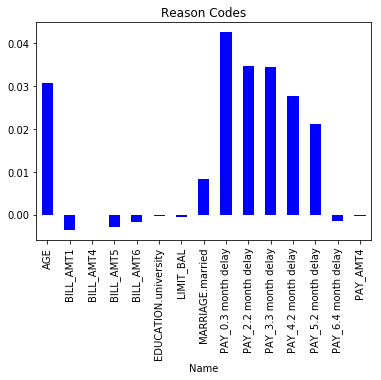

In [26]:
plot_local_contrib(row, local_glm1, X)


In [27]:
preds2 = model.predict(test).drop(['predict', 'p0'])
preds2.columns = [yhat]
practical_sample = test.cbind(preds2)
practical_sample = practical_sample[practical_sample['SEX'] == 'female']
practical_sample.head(rows=3)

gbm prediction progress: |████████████████████████████████████████████████| 100%


ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
4,50000,female,university,married,37,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0.144991
8,100000,female,university,single,23,use of revolving credit,pay duly,pay duly,use of revolving credit,use of revolving credit,pay duly,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0,0.128193
16,50000,female,high school,divorced,23,1 month delay,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,50614,29173,28116,28771,29531,30211,0,1500,1100,1200,1300,1100,0,0.325205


In [28]:
# initialize
local_glm2 = H2OGeneralizedLinearEstimator(lambda_search=True, seed=12345)

# train 
local_glm2.train(x=X, y=yhat, training_frame=practical_sample)

# coefs
print('\nLocal Positive GLM Coefficients:')
for c_name, c_val in sorted(local_glm2.coef().items(), key=operator.itemgetter(1)):
    if c_val > 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))
        
# r2
print('\nLocal GLM R-square:\n%.2f' % local_glm2.r2())

glm Model Build progress: |███████████████████████████████████████████████| 100%

Local Positive GLM Coefficients:
BILL_AMT5:                1.1826997991308345e-07
BILL_AMT2:                1.40866409117354e-07
PAY_2.use of revolving credit: 8.019899530507052e-05
PAY_5.no consumption:     0.0005253910928260071
AGE:                      0.0005358697742774277
EDUCATION.high school:    0.001738945706593454
PAY_6.5 month delay:      0.003746060705692238
EDUCATION.university:     0.0050869233726203505
MARRIAGE.divorced:        0.008137713429375004
PAY_3.2 month delay:      0.009655714764721601
PAY_6.7 month delay:      0.009949478307751001
MARRIAGE.married:         0.010783461117748264
PAY_6.2 month delay:      0.017777285984771147
PAY_4.4 month delay:      0.018246956356881238
PAY_0.5 month delay:      0.02282693801079417
PAY_5.3 month delay:      0.02513913532234654
PAY_2.2 month delay:      0.027053294000875572
PAY_2.3 month delay:      0.027735314903293225
PAY_3.3 month delay:      0.03

glm prediction progress: |████████████████████████████████████████████████| 100%


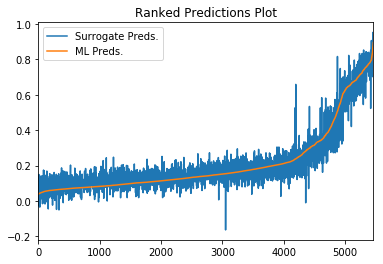

In [29]:
# ranked predictions plot o assess validity of local explanatory model

pred_frame = local_glm2.predict(practical_sample).cbind(practical_sample)\
                       .as_data_frame()[['predict', yhat]]

pred_frame.columns = ['Surrogate Preds.', 'ML Preds.']
pred_frame.sort_values(by='ML Preds.', inplace=True)
pred_frame.reset_index(inplace=True, drop=True)
_ = pred_frame.plot(title='Ranked Predictions Plot')

gbm prediction progress: |████████████████████████████████████████████████| 100%


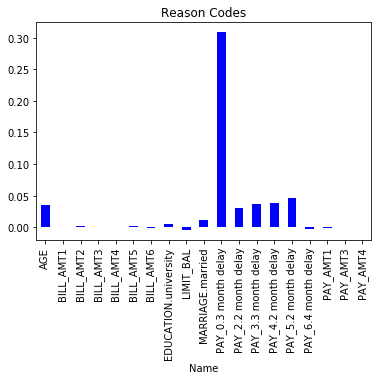

In [30]:
g_pred_ = model.predict(row)['p1'][0, 0]
plot_local_contrib(row, local_glm2, X, g_pred=g_pred_, scale=True)

In [31]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_bd16 closed.


### Summary
In this notebook, LIME was used to explain and generate reason codes for a complex GBM classifier. To do so, local linear models were fit to appropriate samples and linear model coefficients were used to explain the average behavior in the samples and to create reason codes. 
Reason codes were assesed against domain knowledge and reasonable expectations. A ranked prediction plot was also introduced to compare surrogate linear model predictions to GBM model predictions.